<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/The%20ARMA%20Model/arma_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The ARMA Model**

## Import the Packages and Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

## Import the Data

In [35]:
## mount the google drive to fetch the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
## load the dataset
raw_csv_data = pd.read_csv('/content/drive/MyDrive/Data Science/Time Series/Index2018.csv')
raw_csv_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [37]:
## transforming the dataset
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b') # business days as frequency
df_comp = df_comp.fillna(method='ffill')

In [38]:
df_comp['market_value'] = df_comp.ftse

In [39]:
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']

## Splitting the Training and Testing Set

In [40]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The Dickey-Fuller Test

In [41]:
sts.adfuller(df.market_value)

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54854.15304507557)

## The ACF and the PACF

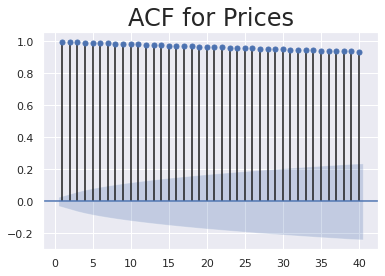

In [42]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF for Prices', size=24)
plt.show()

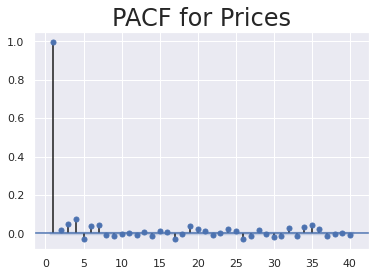

In [43]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, alpha=0.5, method=('ols'))
plt.title('PACF for Prices', size=24)
plt.show()

## Using Returns

returns -> the % change between the values for 2 consecutive periods.

In [44]:
df['returns'] = df.market_value.pct_change(1).mul(100) ## mul 100 used to make it percentage

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## The Log-Likelihood Test

In [45]:
def llr_test(mod_1, mod_2, DF=1):
   """ mod_1, mod_2= models to compare, df=degrees of freedom"""
   L1 = mod_1.fit(trend='nc').llf ## Add trend='ct'
   L2 = mod_2.fit(trend='nc').llf ## log likelihood
   LR = (2*(L2-L1)) ## test statistics
   p = chi2.sf(LR, DF).round(3) ## p-value
   return p

## ARMA(1,1)

In [46]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order=(1,1))
results_ret_ar1_ma1 = model_ret_ar_1_ma_1.fit()
print(results_ret_ar1_ma1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Tue, 02 Aug 2022   AIC                          15841.000
Time:                        08:33:09   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -

The **constant** is significantly different from 0(zero). Since we are using **Returns** it is reasonable to centre around 0 and that is totally acceptable.

Next we see Auto-Regressive is positive and Moving Average is negative. AR is **76%** positive which means a positive tendency between past and present values. Returns move in trends of consecutive positive or negative values.
This leads to periods of persistent increase or decreases when tranlated to prices.

The **negative** coefficients of MA are slightly harder to interpret, it suggests we should be moving away from the past period(t-1) values rather than trying to using them as targets for calibration. We want to prevent our targets from moving, before we have accounted for them.




Since the ARMA is simultaneously an extension of AR(1) and MA(1) we sould execute the Log-Likeligood test to determine iof it is a better predictor.

In [47]:
##LLR test for the AR(1) and MA(1) both individually

model_ret_ar_1 = ARMA(df.returns[1:], order=(1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))

In [48]:
print("\nARMA VS AR", llr_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("\nARMA VS MA", llr_test(model_ret_ma_1, model_ret_ar_1_ma_1))


ARMA VS AR 0.0

ARMA VS MA 0.0


**NOTE :-** In the Log-Likelihood function **trend** changed to 'nc' worked.

## Higer-Lag ARMA Models

In [49]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order=(3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
print(results_ret_ar_3_ma_3.summary())
print("\nLLR test p-value", llr_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF=4))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Tue, 02 Aug 2022   AIC                          15803.030
Time:                        08:33:14   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     

In [50]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order=(3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
print(results_ret_ar_3_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Tue, 02 Aug 2022   AIC                          15805.495
Time:                        08:33:19   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     

Returns in an efficient market should be close to 0 anyway.

None of the p-values for this model are troublesome.

The further back in time we go, the less relevant values and errors become.

In [51]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
print(results_ret_ar_2_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Tue, 02 Aug 2022   AIC                          15805.174
Time:                        08:33:21   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     

In [52]:
print("\nThe LLR test p-value: ", llr_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3))


The LLR test p-value:  0.05


In [53]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order=(3,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
print(results_ret_ar_3_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Tue, 02 Aug 2022   AIC                          15810.144
Time:                        08:33:26   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     

From the above model we can see :

All the p-values apart from the constant are 0(zero), they are significant.

All the MA components has positive coefficients.

All the AR components has negative coefficients.

In [54]:
print("\nThe LLR test p-value : ", llr_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2))


The LLR test p-value :  0.009


In [55]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order=(2,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
print(results_ret_ar_2_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Tue, 02 Aug 2022   AIC                          15838.446
Time:                        08:33:29   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     

From the above model we can see :

2 of it's parameter coefficients are not significant **(0.377  and 0.530)**

Interestingly both non-significant coefficients are associated with the 2nd lag.

This shows that simpler models like the ARMA(1,2) or the ARMA(2,1) would outperform it ARMA(2,2).


In [56]:
## Let's move with ARMA(1,3)
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order=(1,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
print(results_ret_ar_1_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Tue, 02 Aug 2022   AIC                          15805.676
Time:                        08:33:31   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095     

The p-value of the all 4 coefficients are significant.

Usually we would go on to use the Log-likelihood ratio test here to compare it with the ARMA(3,2)

ARMA(3,2) and ARMA(1,3) aren't nested.

**Nested Models**

Let's say there are two models **ARMA(P1,Q1)** and **ARMA(P2,Q2)**.

Model ARMA(p2,Q2) is nested if 3 conditions are satisfied :

1. P1 + Q1 > P2 + Q2

2. P1 >= P2

3. Q1 >= Q2

LLR test is possible if ARMA(P2,Q2) is nested.

In [57]:
## print the 'llf' and information criterion AIC
print("\nARMA(3,2): LL = ", results_ret_ar_3_ma_2.llf, "\tAIC : ", results_ret_ar_3_ma_2.aic)
print("\nARMA(1,3): LL = ", results_ret_ar_1_ma_3.llf, "\tAIC : ", results_ret_ar_1_ma_3.aic)


ARMA(3,2): LL =  -7895.747458514506 	AIC :  15805.494917029013

ARMA(1,3): LL =  -7896.837893752919 	AIC :  15805.675787505837


So the final conclusion is **ARMA(3,2)** is the best model :

1)  All significant coefficients.

2) Outpredicts all less complex alternatives.

## Residuals for Returns

In [58]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


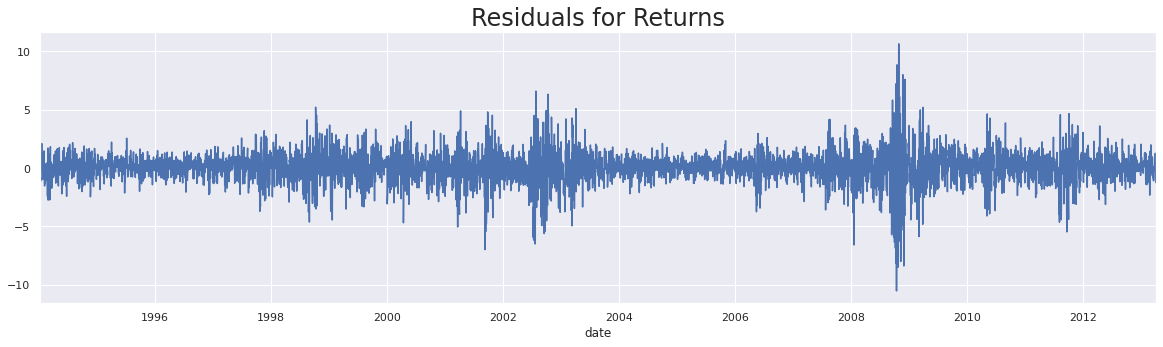

In [59]:
df.res_ret_ar_3_ma_2.plot(figsize=(20,5))
plt.title("Residuals for Returns", size=24)
plt.show()

The above plot shows the volatility in Returns might not be fully comprehendable if we use only ARMA models

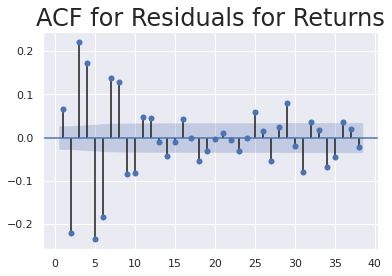

In [60]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False)
plt.title("ACF for Residuals for Returns", size =24)
plt.show()

The above plot shoe that the coefficients are more significant than AR or MA model.

## Re-evaluating the Model Selection

In [61]:
## Go ahead with the model ARMA(5,5) as from the ACF plot
model_ret_ar_5_ma_5 = ARMA(df.returns[1:], order=(5,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
print(results_ret_ar_5_ma_5.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Tue, 02 Aug 2022   AIC                          15788.321
Time:                        08:33:46   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     

In [62]:
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order=(5,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
print(results_ret_ar_5_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 02 Aug 2022   AIC                          15794.623
Time:                        08:49:08   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     

In [63]:
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order=(1,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
print(results_ret_ar_1_ma_5.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 02 Aug 2022   AIC                          15797.947
Time:                        08:49:36   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     

In [64]:
## print the 'llf' and information criterion AIC
print("\nARMA(5,1): LL = ", results_ret_ar_5_ma_1.llf, "\tAIC : ", results_ret_ar_5_ma_1.aic)
print("\nARMA(1,5): LL = ", results_ret_ar_1_ma_5.llf, "\tAIC : ", results_ret_ar_1_ma_5.aic)


ARMA(5,1): LL =  -7889.31128294623 	AIC :  15794.62256589246

ARMA(1,5): LL =  -7890.973460209589 	AIC :  15797.946920419177


In [65]:
## print the 'llf' and information criterion AIC
print("\nARMA(3,2): LL = ", results_ret_ar_3_ma_2.llf, "\tAIC : ", results_ret_ar_3_ma_2.aic)


ARMA(3,2): LL =  -7895.747458514506 	AIC :  15805.494917029013


## Residuals for the New Model

In [66]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


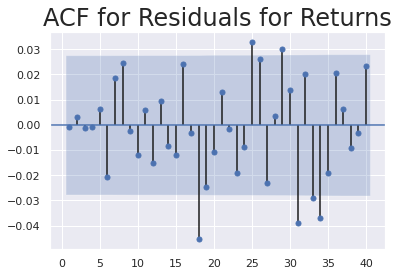

In [67]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero=False, lags=40)
plt.title("ACF for Residuals for Returns", size=24)
plt.show()

We can see that lags from 18 can be included but including higher lags of data will :

predespose the model to failure when facing unfamiliar data.

Will help us know how this specific dataset moves rather than how actual market returns fluctuate.

## ARMA Models for Prices

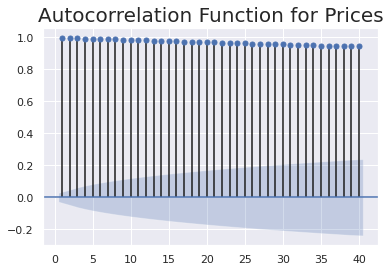

In [68]:
sgt.plot_acf(df.market_value, unbiased=True, zero=False, lags=40)
plt.title("Autocorrelation Function for Prices", size=20)
plt.show()

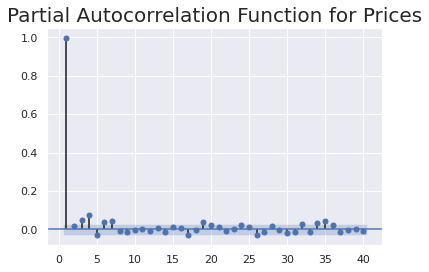

In [69]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title("Partial Autocorrelation Function for Prices", size=20)
plt.show()

An **MA(infinite)**(with certain restrictions) is equivalent to a simple AR model.

As long as we include AR components we should be able to describe the data well.

In [70]:
model_ar_1_ma_1 = ARMA(df.market_value, order=(1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
print(results_ar_1_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.784
Method:                       css-mle   S.D. of innovations             59.248
Date:                Tue, 02 Aug 2022   AIC                          55251.568
Time:                        09:12:50   BIC                          55277.654
Sample:                    01-07-1994   HQIC                         55260.709
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5031.5678    496.810     10.128      0.000    4057.837    6005.298
ar.L1.market_value     0.9985      0.001   1324.999      0.000       0.997       1.000
ma.L1.market_value  

The p-value of MA coefficient is not significant.Therefore we need to examine the **residual** before going towards over parameterized model.

In [71]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


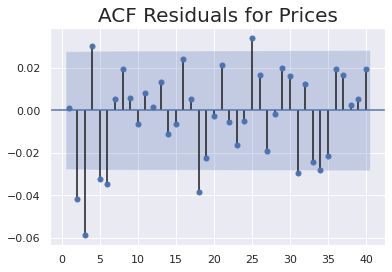

In [72]:
sgt.plot_acf(df.res_ar_1_ma_1, zero=False, lags=40)
plt.title("ACF Residuals for Prices", size=20)
plt.show()

In [73]:
model_ar_6_ma_6 = ARMA(df.market_value, order=(6,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
print(results_ar_6_ma_6.summary())

ValueError: ignored

The above error says the issue with AR coefficients and the last solution is **"pass your own parameters"** .

We do this by passing **"start_ar_lags"** parameter in the **fit()** method of the model. The values are the integers **greater** than the **AR order** of the model.

In [74]:
## we have tried with various start_ar_lags parameters and 11 shows stable result
model_ar_6_ma_6 = ARMA(df.market_value, order=(6,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags=11)
print(results_ar_6_ma_6.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Tue, 02 Aug 2022   AIC                          55203.864
Time:                        09:42:02   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6488    568.148      8.958      0.000    3976.100    6203.198
ar.L1.market_value     1.9272      0.032     59.876      0.000       1.864       1.990
ar.L2.market_value  

We have seen that some of the coefficients are insignificant.

We should lower the total number of lags. We should try all models which contain either 6 AR lags or 6 MA lags.

Here we are trying ARMA(5,6) and ARMA(6,1) models.

In [75]:
model_ar_5_ma_6 = ARMA(df.market_value, order=(5,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags=7)
print(results_ar_5_ma_6.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Tue, 02 Aug 2022   AIC                          55201.726
Time:                        09:47:19   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6464    580.870      8.762      0.000    3951.163    6228.130
ar.L1.market_value     1.3584      0.177      7.655      0.000       1.011       1.706
ar.L2.market_value  

In [76]:
model_ar_6_ma_1 = ARMA(df.market_value, order=(6,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags=7)
print(results_ar_6_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Tue, 02 Aug 2022   AIC                          55206.389
Time:                        09:47:47   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6419    586.495      8.678      0.000    3940.133    6239.151
ar.L1.market_value     1.3921      0.058     23.929      0.000       1.278       1.506
ar.L2.market_value  

## Check for the Log-Likelihood and Information Criterion

In [78]:
## print the 'llf' and information criterion AIC
print("\nARMA(5,6): LL = ", results_ar_5_ma_6.llf, "\tAIC : ", results_ar_5_ma_6.aic)
print("\nARMA(6,1): LL = ", results_ar_6_ma_1.llf, "\tAIC : ", results_ar_6_ma_1.aic)


ARMA(5,6): LL =  -27587.86294825482 	AIC :  55201.72589650964

ARMA(6,1): LL =  -27594.19457096373 	AIC :  55206.38914192746


ARMA(5,6) outperforms ARMA(6,1) as it has higer log-Likelihood and Lower Information Criterion.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


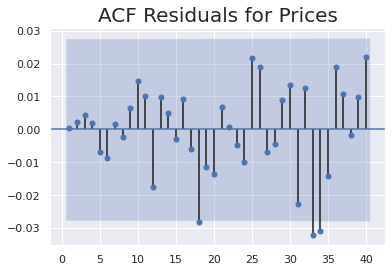

In [79]:
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero=False, lags=40)
plt.title("ACF Residuals for Prices", size=20)
plt.show()

## ARMA for Returns vs ARMA for Prices

In [80]:
print("\nARMA(5,6): LL = ", results_ar_5_ma_6.llf, "\tAIC : ", results_ar_5_ma_6.aic)
print("\nARMA(5,1): LL = ", results_ret_ar_5_ma_1.llf, "\tAIC : ", results_ret_ar_5_ma_1.aic)


ARMA(5,6): LL =  -27587.86294825482 	AIC :  55201.72589650964

ARMA(5,1): LL =  -7889.31128294623 	AIC :  15794.62256589246
